# LA County Board of Supervisors
An analysis of donations to 2nd District candidates

### Read libraries

In [154]:
import json
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import rc
%matplotlib inline
import numpy as np
import geojson
import jenkspy
import altair as alt
alt.renderers.enable('notebook')

import altair as alt
import altair_latimes as lat
alt.renderers.enable('notebook')
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')

ThemeRegistry.enable('latimes')

### Load full list of donations to county candidates since 2007

In [2]:
contributions = pd.read_csv('input/contributions.csv',low_memory=False, dtype={'contributor_zip_code': 'str', 'contributor_zip_code_ext': 'str'})

contributions.contributor_address_2 = contributions.contributor_address_2.fillna('')
contributions.occupation = contributions.occupation.fillna('')
contributions.employer = contributions.employer.fillna('')
contributions.description = contributions.description.fillna('')
contributions.contributor_first_name = contributions.contributor_first_name.fillna('')
contributions.contributor_zip_code_ext = contributions.contributor_zip_code_ext.fillna('')

### Clean up the table

In [3]:
#names
contributions['amount_rcvd'] = contributions['amount_rcvd'].astype(int)
contributions['monthyear'] = pd.to_datetime(contributions['date']).map(lambda dt: dt.replace(day=1))
contributions['type'] = contributions['type'].str.replace("Small Contributor Committee", "Small Donor Committee")
contributions['first_name'] = contributions['first_name'].str.upper()
contributions['last_name'] = contributions['last_name'].str.upper()
contributions['committee_name'] = contributions['committee_name'].str.upper()
contributions['candidate_name'] =  contributions["first_name"].str.title() + ' ' + contributions["last_name"].str.title()
contributions['candidate_name'] = contributions['candidate_name'].str.replace('Holly J. Mitchell', 'Holly Mitchell')
contributions['first_name'] = contributions['first_name'].str.replace('HOLLY J.', 'HOLLY')
contributions["nu_contributor_address"] = contributions["contributor_address"].str.split('#').str[0].str.split(', ').str[0].str.split('Ste').str[0].str.split('Suite').str[0].str.split(',').str[0]
contributions['full_address'] =  contributions["nu_contributor_address"] + ', ' + contributions["contributor_city"] + ', ' + contributions["contributor_state"] + ', ' + contributions["contributor_zip_code"].astype(str)
contributions['candidate_slug'] =  contributions["first_name"].str.lower() + '_' + contributions["last_name"].str.lower()
contributions['candidate_slug'] = contributions['candidate_slug'].str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('.', '').str.replace('\'', '')

#time
contributions['date'] = pd.to_datetime(contributions['date'])
contributions['year'], contributions['month'] = contributions['date'].dt.year, contributions['date'].dt.month
contributions['year'] = contributions['year'].astype(str)
contributions['month'] = contributions['month'].astype(str)
contributions['months'] = contributions['date'].dt.strftime('%m/%Y').astype(str)

### Filter data for recent contributions and money in the District 2 race

In [4]:
recent_contributions = contributions[(contributions['date'] > '2018-06-30')]
second_district_candidates = (['Holly Mitchell','Herb Wesson','Jan Perry','Chan Jeong'])
districttwo = recent_contributions[recent_contributions['candidate_name'].isin(second_district_candidates)]

In [5]:
districttwo.candidate_name.value_counts()

Herb Wesson       976
Jan Perry         895
Holly Mitchell    775
Chan Jeong         82
Name: candidate_name, dtype: int64

### How much did the candidates raise from all locations? 

In [6]:
second_district_totals = districttwo.groupby(['candidate_name'])['amount_rcvd'].sum().reset_index().sort_values(by='candidate_name', ascending=False)

In [7]:
second_district_totals

candidate_name  amount_rcvd
3       Jan Perry       512760
2  Holly Mitchell       568966
1     Herb Wesson      1134738
0      Chan Jeong        46100

### How many individual donations did each candidate receive? 

In [8]:
#Remap donation 'type' codes to be more descriptive
# abbr_indiv_types = {'C' : 'Committee', 'I' : 'Individual', 'O' : 'Other', 'S' : 'Small Committee'}
abbr_indiv_else = {'C' : 'Other', 'I' : 'Individual', 'O' : 'Other', 'S' : 'Other'}
districttwo = districttwo.replace({"type": abbr_indiv_else})

In [9]:
second_district_indiv = pd.pivot_table(districttwo, values='amount_rcvd', index=['candidate_name'], columns=['type'], aggfunc=[np.size], fill_value='0').reset_index()

second_district_indiv.reset_index()

index  candidate_name       size      
type                       Individual Other
0        0      Chan Jeong         64    18
1        1     Herb Wesson        630   346
2        2  Holly Mitchell        454   321
3        3       Jan Perry        796    99

### Which share of each candidates donations came from individuals?

In [10]:
indiv_share = pd.pivot_table(districttwo, values=["amount_rcvd"],
                       index=["candidate_name"], columns=["type"], 
                       aggfunc=len, margins=True, 
                       dropna=True, fill_value=0)
indiv_share_table = indiv_share.div(indiv_share.iloc[:,-1], axis=0).round(2)*100
indiv_share_table.reset_index()

candidate_name amount_rcvd             
type                  Individual Other    All
0         Chan Jeong        78.0  22.0  100.0
1        Herb Wesson        65.0  35.0  100.0
2     Holly Mitchell        59.0  41.0  100.0
3          Jan Perry        89.0  11.0  100.0
4                All        71.0  29.0  100.0

### Normalized bar chart for the share of individual donations

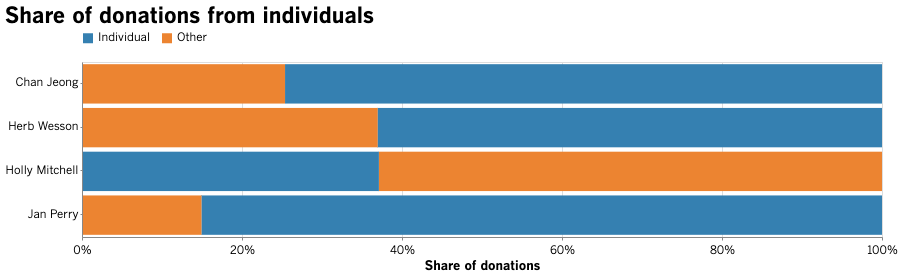

In [11]:
bars = alt.Chart(districttwo, title='Share of donations from individuals').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate_name', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='ascending')
)

(bars).properties(height=175, width=800)

## Where exactly is each donation? 

In [12]:
#after geocoder.ipynb runs, import raw table with lat/lon for each grouped address in 'contributions'

geocoded = pd.read_csv('/Users/mhustiles/Desktop/github/notebooks/campaign-finance/input/geocoded.csv')

In [13]:
geocoded.head(1)

id accuracy                                  formatted_address  \
0   0  ROOFTOP  1250 Long Beach Ave # 104, Los Angeles, CA 900...   

               google_place_id  \
0  ChIJ11zqyoLIwoARZ2-vjBhFJzg   

                                       input_string   latitude   longitude  \
0  1250 Long Beach Ave. 104, Los Angeles, CA, 90021  34.026282 -118.240472   

   number_of_results postcode  \
0                  1    90021   

                                            response status  \
0  {'results': [{'address_components': [{'long_na...     OK   

                              type  
0  establishment,point_of_interest

### How good was Google's geocoding API? 

In [14]:
geocoded.accuracy.value_counts()

ROOFTOP               44116
RANGE_INTERPOLATED     1131
APPROXIMATE             342
GEOMETRIC_CENTER        323
Name: accuracy, dtype: int64

In [15]:
geocoded_clean = geocoded[['accuracy', 'formatted_address', 'input_string', 'latitude', 'longitude']]

### Merge geocoded data onto our 2nd District contributions table

In [16]:
geocoded_join = districttwo.merge(geocoded_clean,left_on='full_address', right_on='input_string', how='left')

In [17]:
len(geocoded_join)

2728

In [18]:
geocoded_join.groupby(["accuracy"])["amount_rcvd"].size()

accuracy
APPROXIMATE             16
GEOMETRIC_CENTER        15
RANGE_INTERPOLATED      48
ROOFTOP               2649
Name: amount_rcvd, dtype: int64

In [19]:
(((geocoded_join.amount_rcvd.sum() - geocoded_join[geocoded_join.accuracy != "ROOFTOP"].amount_rcvd.sum()) / geocoded_join.amount_rcvd.sum())*100).round(2)

97.21

### Let's eliminate donations where Google could find the address. 

In [20]:
geocoded_join = geocoded_join[geocoded_join.accuracy == "ROOFTOP"]

In [21]:
len(geocoded_join)

2649

### Transform locations dataframe into Geo DataFrame (with appropriate coordinate system)

In [22]:
geocoded_join_gdf = gpd.GeoDataFrame(geocoded_join, geometry=gpd.points_from_xy(geocoded_join.longitude, geocoded_join.latitude))

In [23]:
geocoded_join_gdf.crs = {'init': "epsg:4326"}

In [24]:
geocoded_join_gdf.head()

last_name first_name committee_id              committee_name office_type  \
0    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
1    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
2    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
3    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
4    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule   type period_beg_date period_end_date  ...  \
0             NaN        A  Other          1/1/18        12/31/18  ...   
1             NaN        A  Other          1/1/18        12/31/18  ...   
2             NaN        A  Other          1/1/18        12/31/18  ...   
3             NaN        A  Other          1/1/18        12/31/18  ...   
4             NaN        A  Other          1/1/18        12/31/18  ...   

  candidate_slug  year  month   months accuracy  \
0    herb_wesson  2018     12  12/2018  ROOFTOP   
1    herb_wesson  2018     12  12/2018  ROOFTOP   
2    herb_wesson  2018     12  12/2018  ROOFTOP   
3    herb_wesson  2018     12  12/2018  ROOFTOP   
4    herb_wesson  2018     12  12/2018  ROOFTOP   

                             formatted_address  \
0  8530 Stanton Ave, Buena Park, CA 90620, USA   
1  8530 Stanton Ave, Buena Park, CA 90620, USA   
2  249 E Ocean Blvd, Long Beach, CA 90802, USA   
3      1775 K St NW, Washington, DC 20006, USA   
4    630 Shatto Pl, Los Angeles, CA 90005, USA   

                              input_string   latitude   longitude  \
0  8530 Stanton Ave, Buena Park, CA, 90620  33.838914 -117.992636   
1  8530 Stanton Ave, Buena Park, CA, 90620  33.838914 -117.992636   
2  249 E Ocean Blvd, Long Beach, CA, 90802  33.767313 -118.190096   
3      1775 K St NW, Washington, DC, 20006  38.902898  -77.041289   
4    630 Shatto Pl, Los Angeles, CA, 90005  34.062793 -118.289524   

                                 geometry  
0         POINT (-117.9926359 33.8389138)  
1         POINT (-117.9926359 33.8389138)  
2  POINT (-118.1900963 33.76731270000001)  
3   POINT (-77.04128940000001 38.9028976)  
4          POINT (-118.2895243 34.062793)  

[5 rows x 41 columns]

## Import and use LA County geography

### Read the Census blocks, with population/household figures added by county officials

In [25]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Demographics/MapServer/3
blocks = gpd.read_file('/Users/mhustiles/Desktop/data/GIS/LA/LA_county_census_blocks_2010/la_county_blocks_2010_data.geojson')

In [26]:
blocks.columns = blocks.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [27]:
blocks = blocks.to_crs({'init': "epsg:4326"})

In [28]:
len(blocks)

109279

In [29]:
blocks.columns

Index(['objectid', 'ct10', 'bg10', 'cb10', 'ctcb10', 'bg10fip10', 'cen_fip13',
       'la_fip10', 'city', 'comm', 'citycom', 'zcta10', 'puma10', 'hd_2012',
       'hd_name', 'spa_2012', 'spa_name', 'sup_dist', 'sup_label', 'housing10',
       'pop_2010', 'shape.starea', 'shape.stlength', 'ct12', 'bg12',
       'geometry'],
      dtype='object')

In [30]:
blocks['geoid10'] = blocks['ctcb10']

### Merge our contributions/locations data to Census blocks

In [31]:
dist_two_blocks = gpd.sjoin(geocoded_join_gdf, blocks, op='within', how="inner")

In [32]:
dist_two_blocks.columns = dist_two_blocks.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [33]:
second_district_blocks = dist_two_blocks[(dist_two_blocks['last_name'] == 'WESSON') | (dist_two_blocks['last_name'] == 'PERRY') | (dist_two_blocks['last_name'] == 'PERRY') | (dist_two_blocks['last_name'] == 'JEONG') | (dist_two_blocks['last_name'] == 'MITCHELL')]

In [34]:
second_district_blocks.first_name.value_counts()

JAN      780
HERB     756
HOLLY    398
CHAN      72
Name: first_name, dtype: int64

In [100]:
second_district_blocks.to_file("/Users/mhustiles/Desktop/github/notebooks/campaign-finance/output/second_district_blocks.geojson", driver="GeoJSON")

In [36]:
second_district_blocks.head(2)

last_name first_name committee_id              committee_name office_type  \
2    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
7    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule   type period_beg_date period_end_date  ...  \
2             NaN        A  Other          1/1/18        12/31/18  ...   
7             NaN        A  Other          1/1/18        12/31/18  ...   

    spa_name sup_dist   sup_label  housing10 pop_2010  shape.starea  \
2  South Bay        4  District 4          0        0  68632.442383   
7  South Bay        4  District 4          0        0  68632.442383   

  shape.stlength    ct12     bg12     geoid10  
2    1069.300144  576001  5760012  5760012053  
7    1069.300144  576001  5760012  5760012053  

[2 rows x 68 columns]

## Donations by block

### How much did candidates raise by block?

In [37]:
sum_by_block = pd.pivot_table(second_district_blocks, values='amount_rcvd', index=['geoid10'], columns=['candidate_slug'], aggfunc=np.sum, fill_value=0).reset_index()
sum_by_block.columns = sum_by_block.columns.to_series().str.join('')

In [38]:
sum_by_block["total"] = sum_by_block.sum(axis=1)

### How much did all candidates raise in each block? 

In [39]:
sum_by_block = sum_by_block.sort_values("total", ascending=False)

In [40]:
sum_by_block.head(2)

candidate_slug     geoid10  chan_jeong  herb_wesson  holly_mitchell  \
1051            5760012053           0         8648            1000   
291             2077101011           0         3000            6615   

candidate_slug  jan_perry  total  
1051                    0   9648  
291                     0   9615

### How much was donated to all candidates from L.A. County blocks? 

In [41]:
sum_by_block.total.sum()

1578057

### How many blocks in LA County donated? 

In [42]:
sum_by_block.total.count()

1392

### Which 2nd District candidate received the most on each block? 

In [43]:
#create a dummy field because i'm bad at idxmax
sum_by_block['tie'] = '0'

In [44]:
#reshape dataframe
sum_by_block_slim = sum_by_block[['geoid10', 'tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell','total']]

In [45]:
sum_by_block_slim['tie'] = sum_by_block_slim['tie'].astype(int)
sum_by_block_slim['geoid10'] = sum_by_block_slim['geoid10'].astype(str)

In [46]:
#who won each block?
sum_by_block_slim['winner_dist_two'] = sum_by_block_slim[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].idxmax(axis=1)

In [47]:
#how much did each block winner raise from there? 
sum_by_block_slim['winner_total'] = sum_by_block_slim[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].max(axis=1)

In [48]:
sum_by_block_slim.head()

candidate_slug     geoid10  tie  chan_jeong  herb_wesson  jan_perry  \
1051            5760012053    0           0         8648          0   
291             2077101011    0           0         3000          0   
391             2121021001    0         300         9300          0   
689             2677002027    0           0            0          0   
1362            8004061003    0           0         7500          0   

candidate_slug  holly_mitchell  total winner_dist_two  winner_total  
1051                      1000   9648     herb_wesson          8648  
291                       6615   9615  holly_mitchell          6615  
391                          0   9600     herb_wesson          9300  
689                       7500   7500  holly_mitchell          7500  
1362                         0   7500     herb_wesson          7500

### Remove 2nd District rows with no contributions

In [49]:
sum_by_block_slim = sum_by_block_slim[(sum_by_block_slim['winner_total'] != 0)]

### How many blocks did each 2nd District candidate win?

In [50]:
sum_by_block_slim.winner_dist_two.value_counts()

herb_wesson       578
jan_perry         510
holly_mitchell    244
chan_jeong         56
Name: winner_dist_two, dtype: int64

### How much did each 2nd District candidate raise from just LA blocks?

In [51]:
sum_by_block_slim[['chan_jeong','herb_wesson','jan_perry','holly_mitchell']].agg('sum')

candidate_slug
chan_jeong         38100
herb_wesson       865551
jan_perry         455135
holly_mitchell    219271
dtype: int64

In [52]:
len(sum_by_block_slim)

1388

In [53]:
len(blocks)

109279

### Merge the blocks geography back onto our 2nd District winners table

In [96]:
second_district_blocks_geo = blocks.merge(sum_by_block_slim, on='geoid10')

In [101]:
second_district_blocks_geo.to_file('output/second_district_blocks_geo.geojson', driver="GeoJSON")

In [98]:
second_district_blocks_geo.head(2)

objectid    ct10     bg10  cb10      ctcb10     bg10fip10 cen_fip13  \
0    100013  701201  7012013  3004  7012013004  701201370000     70000   
1    100018  226002  2260021  1002  2260021002  226002144000     44000   

  la_fip10          city                comm  ...  \
0    70000  Santa Monica        Santa Monica  ...   
1    44000   Los Angeles  Wholesale District  ...   

                                            geometry     geoid10 tie  \
0  POLYGON ((-118.4938122283859 34.03863684039477...  7012013004   0   
1  POLYGON ((-118.2485401870849 34.04194385415874...  2260021002   0   

   chan_jeong herb_wesson  jan_perry holly_mitchell total winner_dist_two  \
0           0        1500          0              0  1500     herb_wesson   
1           0           0       1500              0  1500       jan_perry   

   winner_total  
0          1500  
1          1500  

[2 rows x 35 columns]

## Donations by *Los Angeles Times* neighborhoods

In [102]:
neighborhoods = gpd.read_file('/Users/mhustiles/Desktop/data/GIS/LA/la-county-city-neighborhoods.geojson')
neighborhoods.columns = neighborhoods.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

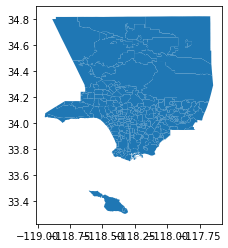

In [103]:
neighborhoods.plot()

In [104]:
second_district_hoods = gpd.sjoin(geocoded_join_gdf, neighborhoods, op='within', how="inner")

In [105]:
second_district_hoods.head(2)

last_name first_name committee_id              committee_name office_type  \
2    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   
7    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule type_left period_beg_date period_end_date  ...  \
2             NaN        A     Other          1/1/18        12/31/18  ...   
7             NaN        A     Other          1/1/18        12/31/18  ...   

         slug                                  set  \
2  long-beach  L.A. County Neighborhoods (Current)   
7  long-beach  L.A. County Neighborhoods (Current)   

                                 kind  external_i        name  \
2  L.A. County Neighborhood (Current)  long-beach  Long Beach   
7  L.A. County Neighborhood (Current)  long-beach  Long Beach   

                                      display_na           sqmi  \
2  Long Beach L.A. County Neighborhood (Current)  52.1003673205   
7  Long Beach L.A. County Neighborhood (Current)  52.1003673205   

        type_right name_1 slug_1  
2  standalone-city   None   None  
7  standalone-city   None   None  

[2 rows x 52 columns]

In [61]:
second_district_hoods.columns = second_district_hoods.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### How much did each of the candidates raise by neighborhood?

In [106]:
sum_by_hood = pd.pivot_table(second_district_hoods, values='amount_rcvd', index=['name'], columns=['candidate_slug'], aggfunc=np.sum, fill_value=0).reset_index()

In [107]:
sum_by_hood["total"] = sum_by_hood.sum(axis=1)

In [108]:
sum_by_hood.columns = sum_by_hood.columns.to_series().str.join('')

### How much did all of the candidates raise by neighborhood?

In [109]:
sum_by_hood = sum_by_hood.sort_values("total", ascending=False)

In [142]:
sum_by_hood.head(20)

candidate_slug                     name  chan_jeong  herb_wesson  \
45                             Downtown        2750        63788   
85                            Koreatown        7900        82850   
16                        Beverly Hills           0        46150   
20                            Brentwood           0        15949   
96                           Long Beach         500        30248   
140                        Santa Monica           0        18750   
179                            Westwood           0        18500   
54                               Encino           0        24100   
120                            Pasadena           0        12950   
141                            Sawtelle           0         6125   
28                         Century City        1500        14000   
103                        Mid-Wilshire        2950         9500   
90                       Ladera Heights           0         6800   
175                         Westchester           0        15900   
99                      Manhattan Beach           0        23300   
176                            Westlake        5600        10750   
166             View Park-Windsor Hills           0         7800   
97                            Los Feliz           0        14750   
40                          Culver City           0         8600   
68                         Hancock Park         600         7800   

candidate_slug  holly_mitchell  jan_perry   total tie  
45                       13965      68300  148803   0  
85                        8000       4350  103100   0  
16                        4100      26080   76330   0  
20                        7000      28350   51299   0  
96                        3750       5250   39748   0  
140                       7500      11900   38150   0  
179                       7500      10000   36000   0  
54                        3500       6200   33800   0  
120                       8180       9925   31055   0  
141                       9685      11900   27710   0  
28                        3650       7625   26775   0  
103                       3960       9775   26185   0  
90                       11825       6650   25275   0  
175                       3050       5350   24300   0  
99                         500          0   23800   0  
176                       4900       1200   22450   0  
166                      10006       4500   22306   0  
97                        1100       5800   21650   0  
40                        3900       7700   20200   0  
68                           0      11350   19750   0

### How much was donated to all candidates from L.A. County neighborhoods? 

In [143]:
sum_by_hood.total.sum()

1577557

### How many neighborhoods in LA County donated? 

In [144]:
sum_by_hood.total.count()

185

### Which 2nd District candidate received the most on each block? 

In [145]:
#create a dummy field because i'm bad at idxmax
sum_by_hood['tie'] = '0'

In [146]:
#reshape dataframe
sum_by_hood_winner = sum_by_hood[['name', 'tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell','total']]

In [147]:
sum_by_hood_winner['tie'] = sum_by_hood_winner['tie'].astype(int)
sum_by_hood_winner['name'] = sum_by_hood_winner['name'].astype(str)

In [148]:
#who won each block?
sum_by_hood_winner['winner_dist_two'] = sum_by_hood_winner[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].idxmax(axis=1)

In [149]:
#how much did each block winner raise from there? 
sum_by_hood_winner['winner_total'] = sum_by_hood_winner[['tie','chan_jeong','herb_wesson','jan_perry','holly_mitchell']].max(axis=1)

### Which were the top neighborhoods for each candidate? 

In [150]:
sum_by_hood_winner.head(10)

candidate_slug           name  tie  chan_jeong  herb_wesson  jan_perry  \
45                   Downtown    0        2750        63788      68300   
85                  Koreatown    0        7900        82850       4350   
16              Beverly Hills    0           0        46150      26080   
20                  Brentwood    0           0        15949      28350   
96                 Long Beach    0         500        30248       5250   
140              Santa Monica    0           0        18750      11900   
179                  Westwood    0           0        18500      10000   
54                     Encino    0           0        24100       6200   
120                  Pasadena    0           0        12950       9925   
141                  Sawtelle    0           0         6125      11900   

candidate_slug  holly_mitchell   total winner_dist_two  winner_total  
45                       13965  148803       jan_perry         68300  
85                        8000  103100     herb_wesson         82850  
16                        4100   76330     herb_wesson         46150  
20                        7000   51299       jan_perry         28350  
96                        3750   39748     herb_wesson         30248  
140                       7500   38150     herb_wesson         18750  
179                       7500   36000     herb_wesson         18500  
54                        3500   33800     herb_wesson         24100  
120                       8180   31055     herb_wesson         12950  
141                       9685   27710       jan_perry         11900

### Remove 2nd District rows with no contributions

In [124]:
sum_by_hood_winner = sum_by_hood_winner[(sum_by_hood_winner['winner_total'] != 0)]

### How many neighborhoods did each 2nd District candidate win?

In [125]:
sum_by_hood_winner.winner_dist_two.value_counts()

herb_wesson       120
jan_perry          43
holly_mitchell     16
chan_jeong          6
Name: winner_dist_two, dtype: int64

### How much did each 2nd District candidate raise from just LA neighborhoods?

In [126]:
sum_by_hood_winner[['chan_jeong','herb_wesson','jan_perry','holly_mitchell']].agg('sum')

candidate_slug
chan_jeong         38100
herb_wesson       865051
jan_perry         455135
holly_mitchell    219271
dtype: int64

### Merge the neighborhoods/winner geography back onto our 2nd District winners table

In [127]:
second_district_hoods = neighborhoods.merge(sum_by_hood_winner, on='name')

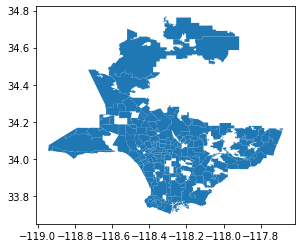

In [128]:
second_district_hoods.plot()

### Export spatial file with winners, totals by neighborhood

In [339]:
second_district_hoods.to_file('output/second_district_hoods_sum.geojson', driver="GeoJSON")

## Plot the donations

### Choropleth map with neighborhood totals

In [361]:
breaks = jenkspy.jenks_breaks(second_district_hoods.winner_total, nb_class=7)

In [363]:
def get_group(value):
    for i, b in enumerate(breaks):
        if value <= breaks[i+1]:
            return i

In [364]:
second_district_hoods['winner_group'] = second_district_hoods.winner_total.apply(get_group)

### Winner group data to file

In [344]:
second_district_hoods.to_file("output/second_district_hoods_winner_groups.geojson", driver="GeoJSON")

### Feed GeoJSON to Altair

In [345]:
geojson = json.loads(second_district_hoods.to_json())

In [346]:
features = alt.Data(values=geojson['features'])

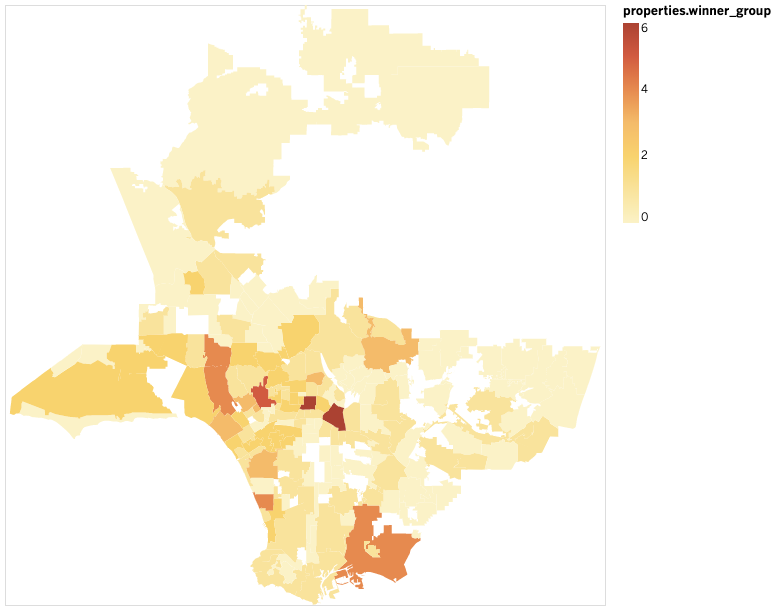

In [347]:
alt.Chart(features).mark_geoshape().encode(
    color='properties.winner_group:Q'
).properties(
    width=600,
    height=600
)

### Categorical map with winners

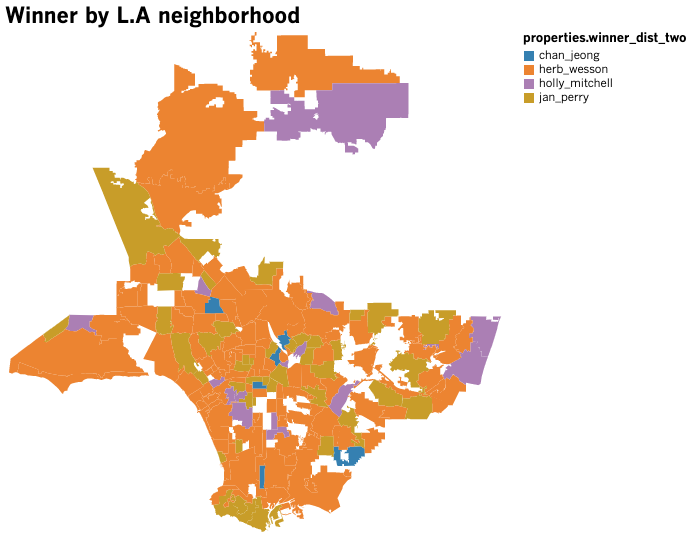

In [275]:
alt.Chart(features).mark_geoshape().encode(
    color='properties.winner_dist_two:N',
).properties(
    width=500,
    height=500, title='Winner by L.A neighborhood'
).configure_view(
    strokeWidth=0
)

### How much did each candidate raise — by month — in 2019? 

In [81]:
districttwo_time = districttwo.groupby(['monthyear','year','month', 'candidate_name'], as_index=False).agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

districttwo_time
flat_columns = [''.join(t) for t in districttwo_time.columns]
districttwo_time.columns = flat_columns
districttwo_time['amount_rcvdmean'] = districttwo_time['amount_rcvdmean'].astype(int)
districttwo_time['amount_rcvdmean'] = districttwo_time['amount_rcvdmean'].round()
districttwo_time.head(10)
districttwo_time['months'] = districttwo_time['monthyear'].dt.strftime('%m/%d/%Y').astype(str)
districttwo_time

monthyear  year month  candidate_name  amount_rcvdsize  amount_rcvdmean  \
0  2018-12-01  2018    12     Herb Wesson              357             1275   
1  2019-01-01  2019     1     Herb Wesson               78             1048   
2  2019-01-01  2019     1       Jan Perry               59              642   
3  2019-02-01  2019     2     Herb Wesson               38             1056   
4  2019-02-01  2019     2  Holly Mitchell              477              837   
5  2019-02-01  2019     2       Jan Perry               95              846   
6  2019-03-01  2019     3     Herb Wesson              144             1191   
7  2019-03-01  2019     3  Holly Mitchell               20              574   
8  2019-03-01  2019     3       Jan Perry              112              670   
9  2019-04-01  2019     4     Herb Wesson              102             1086   
10 2019-04-01  2019     4  Holly Mitchell               83              527   
11 2019-04-01  2019     4       Jan Perry              126              534   
12 2019-05-01  2019     5      Chan Jeong               77              585   
13 2019-05-01  2019     5     Herb Wesson               99             1062   
14 2019-05-01  2019     5  Holly Mitchell               47              568   
15 2019-05-01  2019     5       Jan Perry               93              556   
16 2019-06-01  2019     6      Chan Jeong                5              200   
17 2019-06-01  2019     6     Herb Wesson              158             1075   
18 2019-06-01  2019     6  Holly Mitchell              148              589   
19 2019-06-01  2019     6       Jan Perry              410              488   

    amount_rcvdsum      months  
0           455299  12/01/2018  
1            81800  01/01/2019  
2            37930  01/01/2019  
3            40150  02/01/2019  
4           399665  02/01/2019  
5            80375  02/01/2019  
6           171516  03/01/2019  
7            11490  03/01/2019  
8            75150  03/01/2019  
9           110837  04/01/2019  
10           43800  04/01/2019  
11           67325  04/01/2019  
12           45100  05/01/2019  
13          105223  05/01/2019  
14           26702  05/01/2019  
15           51725  05/01/2019  
16            1000  06/01/2019  
17          169913  06/01/2019  
18           87309  06/01/2019  
19          200255  06/01/2019

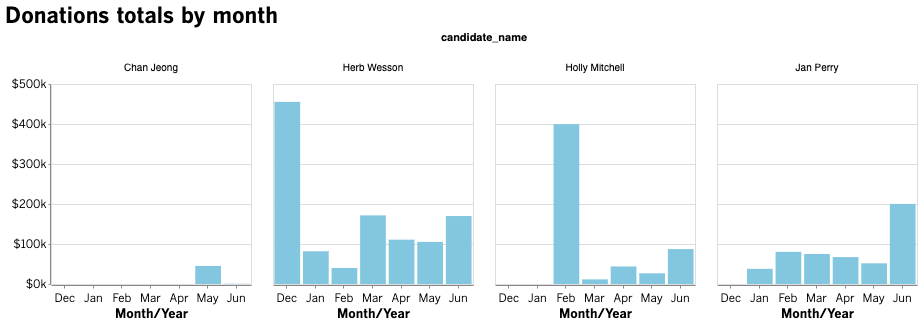

In [82]:
base = alt.Chart(districttwo_time, title='').mark_bar().encode(
    x=alt.X("months:O", 
            timeUnit="yearmonth",
            title="Month/Year",
            axis=alt.Axis(format="%b")
           ),
    y=alt.Y(
        'amount_rcvdsum:Q',
        title="",
        axis=alt.Axis(format="$1s", tickCount=4)
        )
    ).properties(height=200, width=200).facet(
    column='candidate_name:N', title="Donations totals by month"
)
base

### Load 2nd District boundary data

In [130]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Demographics/MapServer/3
district = gpd.read_file('/Users/mhustiles/Desktop/data/GIS/LA/second-district.geojson')

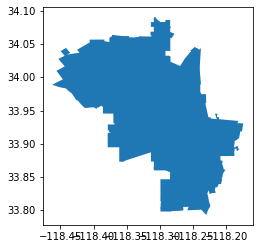

In [131]:
district.plot()

### Which share of each candidate's donations came from outside the district? 

In [132]:
district_donations = gpd.sjoin(geocoded_join_gdf, district, op='within', how="inner")

In [133]:
district_donations.head(1)

last_name first_name committee_id              committee_name office_type  \
4    WESSON       HERB      1414475  WESSON FOR SUPERVISOR 2020         CSU   

  district_number schedule   type period_beg_date period_end_date  ...  \
4             NaN        A  Other          1/1/18        12/31/18  ...   

                            input_string   latitude   longitude  \
4  630 Shatto Pl, Los Angeles, CA, 90005  34.062793 -118.289524   

                         geometry index_right OBJECTID DISTRICT       LABEL  \
4  POINT (-118.2895243 34.062793)           0      816        2  District 2   

  Shape.STArea() Shape.STLength()  
4   4.511283e+09    477421.592662  

[1 rows x 47 columns]

In [134]:
district_totals = district_donations.groupby(['candidate_slug']).agg({'amount_rcvd':np.sum}).reset_index().sort_values(by='candidate_slug', ascending=False)

In [135]:
district_totals.head(4)

candidate_slug  amount_rcvd
3       jan_perry        97380
2  holly_mitchell        78981
1     herb_wesson       227105
0      chan_jeong        14450

In [136]:
district_totals['outside'] = (second_district_totals.amount_rcvd - district_totals.amount_rcvd).round(2)
district_totals['share_district'] = (district_totals.amount_rcvd / second_district_totals.amount_rcvd * 100).round(2)
district_totals_clean = district_totals.rename(columns={"amount_rcvd": "inside", 'candidate_slug': 'candidate'})

In [137]:
district_totals_clean

candidate  inside  outside  share_district
3       jan_perry   97380   415380           18.99
2  holly_mitchell   78981   489985           13.88
1     herb_wesson  227105   907633           20.01
0      chan_jeong   14450    31650           31.34

In [138]:
district_totals_melt = pd.melt(district_totals_clean, col_level=0, id_vars=['candidate'], value_vars=['inside', 'outside'])

In [139]:
district_totals_melt

candidate variable   value
0       jan_perry   inside   97380
1  holly_mitchell   inside   78981
2     herb_wesson   inside  227105
3      chan_jeong   inside   14450
4       jan_perry  outside  415380
5  holly_mitchell  outside  489985
6     herb_wesson  outside  907633
7      chan_jeong  outside   31650

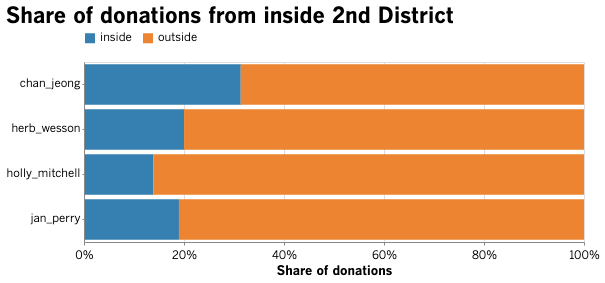

In [140]:
bars = alt.Chart(district_totals_melt, title='Share of donations from inside 2nd District').mark_bar().encode(
    x=alt.X('sum(value)', stack="normalize", title="Share of donations", axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate', title=""),
    color=alt.Color('variable',legend=alt.Legend(title="",orient='top')),
    order=alt.Order('variable', sort='ascending')
)

(bars).properties(height=180, width=500)

### How much have the candidate raised in the other four districts?